In [1]:
import logging
import warnings

from IPython.display import Markdown
from sklearn import datasets
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import featuretools as ft
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
warnings.filterwarnings(action='ignore', category=FutureWarning, module='featuretools')
warnings.filterwarnings(action='ignore', category=UserWarning, module='woodwork')

# 1. 数値変数の特徴量生成・学習

## 標準化

In [3]:
X_df, _ = datasets.load_iris(return_X_y=True, as_frame=True)
X_train_df, X_test_df = train_test_split(X_df, train_size=0.7, random_state=1234)
scaler = StandardScaler()

# 標準化パラメータの学習
scaler.fit(X_train_df)
scaler.mean_  # 平均: array([5.86095238, 3.05619048, 3.8152381 , 1.23428571])
scaler.scale_  # 標準偏差: array([0.80622521, 0.44591774, 1.74682193, 0.76517394])

# 評価データについて、標準化した特徴量の生成
X_test_std = scaler.transform(X_test_df)
X_test_std_df = pd.DataFrame(X_test_std, columns=scaler.feature_names_in_)

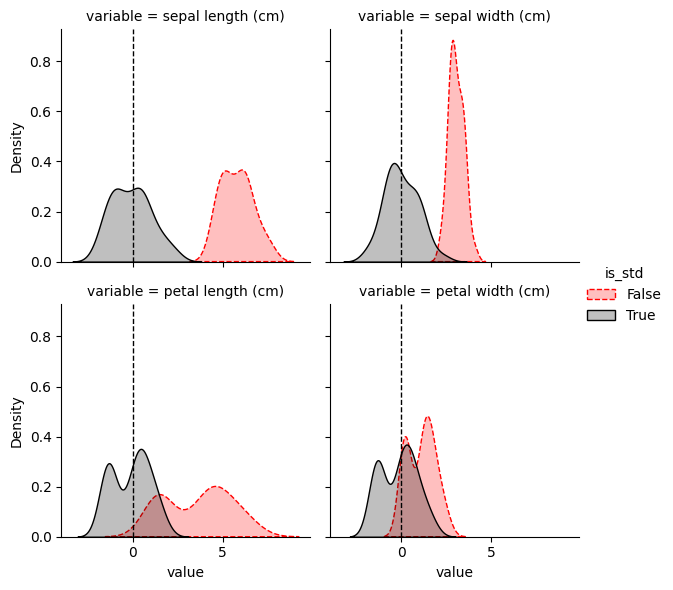

In [4]:
X_test_df["is_std"] = False
X_test_std_df["is_std"] = True
df = pd.concat([X_test_df, X_test_std_df])
df = pd.melt(df, id_vars="is_std", value_vars=df.columns.drop("is_std"))

g = sns.FacetGrid(
    df, col="variable", hue="is_std",
    hue_kws={"color": ["red", "black"], "linestyle": ["--", "-"]},
    col_wrap=2, legend_out=True,
)
g.map(sns.kdeplot, "value", fill=True).add_legend()
for ax in g.axes:
    ax.axvline(0, linestyle="--", linewidth=1, color="black")


# 2. カテゴリ変数の特徴量生成・学習

## ワンホットエンコーディング（one-hot encoding）

In [5]:
df = sns.load_dataset("iris")
df_train, df_test = train_test_split(df, train_size=0.7, random_state=1234)
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)
ohe = OneHotEncoder()

# ワンホットエンコーディングパラメータの学習
ohe.fit(df["species"].to_frame())
ohe.categories_  # カテゴリのリスト: array(['setosa', 'versicolor', 'virginica'])

# 評価データについて、ワンホットエンコーディングした特徴量の生成
df_test_ohe = ohe.transform(df_test["species"].to_frame())

pd.concat(
    [
        df_test["species"],
        pd.DataFrame(df_test_ohe.toarray(),
                     columns=ohe.get_feature_names_out(["species"])).astype(int)
    ],
    axis=1
).head()


,species,species_setosa,species_versicolor,species_virginica
0,versicolor,0,1,0
1,versicolor,0,1,0
2,virginica,0,0,1
3,setosa,1,0,0
4,versicolor,0,1,0


In [6]:
df = sns.load_dataset("iris").sample(5, random_state=1234)
pd.concat(
    [
        df["species"],
        pd.get_dummies(df["species"], prefix="species")
    ],
    axis=1
).reset_index(drop=True)


,species,species_setosa,species_versicolor,species_virginica
0,versicolor,False,True,False
1,versicolor,False,True,False
2,virginica,False,False,True
3,setosa,True,False,False
4,versicolor,False,True,False


## ラベルエンコーディング（label encoding）

In [17]:
df = sns.load_dataset("iris")
df_train, df_test = train_test_split(df, train_size=0.7, random_state=1234)
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)
le = LabelEncoder()

# ラベルエンコーディングパラメータの学習
le.fit(df_train["species"])
le.classes_  # カテゴリのリスト: array(['setosa', 'versicolor', 'virginica'])

# 評価データについて、ラベルエンコーディングした特徴量の生成
df_test_le = le.transform(df_test["species"])

pd.concat(
    [
        df_test["species"],
        pd.DataFrame(df_test_le, columns=["le(species)"])
    ],
    axis=1
).head()


,species,le(species)
0,versicolor,1
1,versicolor,1
2,virginica,2
3,setosa,0
4,versicolor,1


# 4. 欠損値の扱い

In [19]:
class ClWithImputationPipeline:
    scaler = StandardScaler()
    
    def __init__(self, X_cols, y_col, clf, imputer=None):
        self.X_cols = X_cols
        self.y_col = y_col
        self.clf = clf
        self.imputer = imputer
    
    def shape(self, df, phase):
        df.reset_index(drop=True, inplace=True)
        
        X_df = pd.DataFrame(self.scaler.transform(df[self.X_cols]),
                            columns=self.X_cols)
        
        if self.imputer is not None:
            X_df = pd.DataFrame(self.imputer.transform(X_df),
                                columns=self.X_cols)
        df2 = pd.concat([X_df, df[y_col]], axis=1).dropna()
        
        dropped = df.shape[0] - df2.shape[0]
        if dropped != 0:
            logging.warning(f"{dropped} of {df.shape[0]} samples were dropped for {phase}")
        
        X, y = df2[df2.columns.difference([y_col])], df2[y_col]
        return X, y
    
    def fit(self, df):
        self.scaler.fit(df[self.X_cols])

        if self.imputer is not None:
            self.imputer.fit(df[self.X_cols])

        X, y = self.shape(df, "fitting")
        self.clf.fit(X, y)
        return self.clf.score(X, y)
    
    def score(self, df):
        X, y = self.shape(df, "prediction")
        return self.clf.score(X, y)
    

def fit_transform(train_df, test_df, X_cols, y_col):
    for imputer in [
        None,
        SimpleImputer(strategy="constant"), # 定数代入
        SimpleImputer(strategy="mean"),     # 平均補完
        SimpleImputer(strategy="most_frequent"),
        IterativeImputer(random_state=1234)
    ]:
        pl = ClWithImputationPipeline(
            X_cols, y_col,
            clf=LogisticRegression(solver="newton-cg"),
            imputer=imputer,
        )
        train_score = pl.fit(train_df)
        test_score = pl.score(test_df)
        display(Markdown(f"Imputer={imputer} ... training: {train_score:.3f} / testing: {test_score:.3f}"))

In [20]:
df = sns.load_dataset("planets")
train_df, test_df = train_test_split(df, train_size=0.7, random_state=1234)
X_cols = ["number", "orbital_period", "mass", "distance", "year"]
y_col = "method"

display(Markdown("## The number of null namples"))
display(pd.isnull(df).sum())

display(Markdown("## Accuracy"))
fit_transform(train_df, test_df, X_cols, y_col)


## The number of null namples

method              0
number              0
orbital_period     43
mass              522
distance          227
year                0
dtype: int64

## Accuracy

Imputer=None ... training: 0.997 / testing: 1.000

Imputer=SimpleImputer(strategy='constant') ... training: 0.852 / testing: 0.836

Imputer=SimpleImputer() ... training: 0.885 / testing: 0.887

Imputer=SimpleImputer(strategy='most_frequent') ... training: 0.883 / testing: 0.884

/Users/toshi/python-business-ml-starter/venv1/lib/python3.11/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


Imputer=IterativeImputer(random_state=1234) ... training: 0.909 / testing: 0.929

# 5. テーブルの結合

In [28]:
property_df = pd.read_csv("不動産ダミーデータ.csv")
station_df = pd.read_csv("駅マスタ.csv")
review_df = pd.read_csv("レビュー.csv")

In [29]:
# エンティティセットの定義
es = ft.EntitySet(id="real_estate")
es = es.add_dataframe(
    dataframe_name="property",
    dataframe=property_df,
    index="property_id"
)
es = es.add_dataframe(
    dataframe_name="station",
    dataframe=station_df,
    index="station_id"
)
es = es.add_dataframe(
    dataframe_name="review",
    dataframe=review_df,
    index="review_id"
)

In [30]:
# リレーションシップの定義
es = es.add_relationship(
    parent_dataframe_name="station",
    parent_column_name="station_id",
    child_dataframe_name="property",
    child_column_name="station_id",
)
es = es.add_relationship(
    parent_dataframe_name="property",
    parent_column_name="property_id",
    child_dataframe_name="review",
    child_column_name="property_id",
)

In [31]:
# 特徴量テーブルの生成
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="property",
    drop_contains=["rent_price"]
)

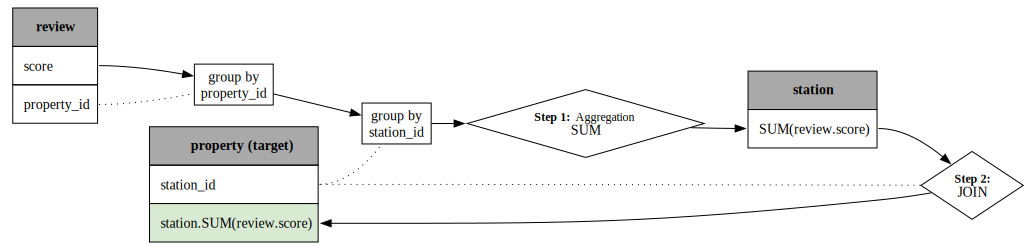

In [32]:
feature_defs[-1]  # <Feature: station.SUM(review.score)>
ft.graph_feature(feature_defs[-1])